In [123]:
# Run this code to unzip the Skin Diseases Data into a "dataset" folder
import zipfile as zf
files = zf.ZipFile("archive.zip", 'r')
files.extractall('dataset')
files.close()

In [45]:
# Useful Imports

# Torch Imports
import torch 
import torch.nn as nn
import torch.utils.data as data

# Torchvision Imports
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Utility Imports
import matplotlib.pyplot as plt
import numpy as np

# Metric and Matrix Imports
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score

# Bayesian Optimization Imports
import GPyOpt

In [46]:
# Converts every image to 256x256 dimension, randomly change images for generalization,
# into a tensor, normalize pixel values
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Converts every image to 256x256 dimension and into a Tensor
val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loads each subset directory from your "dataset" folder
train_dataset = datasets.ImageFolder(root='dataset/Train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='dataset/Test', transform=val_test_transform)
val_dataset = datasets.ImageFolder(root='dataset/Val', transform=val_test_transform)

# Hyper Parameters for dataset organization and processing
batch_size = 100
num_workers = 3
# Dataloader for each subset which will batch, shuffle, and parallel load the data
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [47]:
# Total images in each subset
print('Train data: ', len(train_dataset))
print('Test data: ', len(test_dataset))
print('Valid data: ', len(val_dataset))

Train data:  1198
Test data:  389
Valid data:  250


torch.Size([3, 128, 128])
tensor(0)
torch.Size([100, 3, 128, 128])
torch.Size([100])


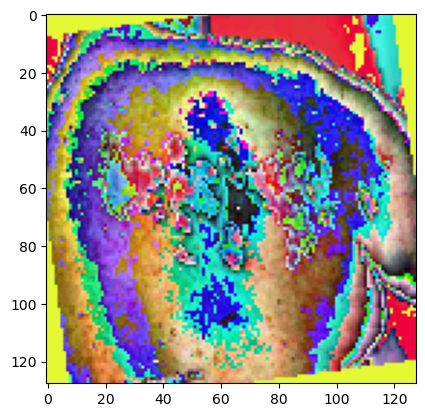

In [48]:
# Check a batch of data
images, labels = next(iter(train_dataloader))

print(images[0].size()) # Number of Colors (RGB=3), Height=256, Width=256
print(labels[0]) # Herpes=0, Melanoma=1, Monkeypox=2, Sarampion=3, Varicela=4
print(images.shape)
print(labels.shape)

# Will show the image sampled
image = transforms.ToPILImage()(images[0])
plt.imshow(image)
plt.show()

In [49]:
# Calculates output layer size, convenient when making multiple hidden layers
image_size = 14
kernel_size = 3
padding = 0
stride = 1
pool = 2

output_shape = np.floor((((image_size - kernel_size + (2 * padding)) / stride) + 1) / pool)
print(output_shape)

6.0


In [63]:
# Custom CNN Model

class CustomCNN(nn.Module):
    def __init__(self, dropout, kernel, channels):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, channels, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2)) # Output Layer = 62

        output_shape = np.floor(((128 - kernel) + 1) / 2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(channels, channels*2, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2)) # Output Layer = 30

        output_shape = np.floor(((output_shape - kernel) + 1) / 2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(channels*2, channels*4, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels*4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2)) # Output Layer = 14

        output_shape = np.floor(((output_shape - kernel) + 1) / 2)
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(channels*4, channels*2, kernel_size=kernel, stride=1, padding=0), 
            nn.BatchNorm2d(channels*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2, stride=2)) # Output Layer = 6

        output_shape = np.floor(((output_shape - kernel) + 1) / 2)

        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Sequential(
            nn.Linear(channels*2*int(output_shape)*int(output_shape), channels*2),
            nn.ReLU())

        self.fc2 = nn.Sequential(
            nn.Linear(channels*2, channels),
            nn.ReLU())
        
        self.fc3 = nn.Linear(channels, 5)

    def forward(self, out):
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [64]:
# Allows model to run on GPU if it is present
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [65]:
# Test run, should output torch.Size([batch_size, classes])
custom_cnn = CustomCNN(dropout=0.3, kernel=3, channels=32).to(device)
output = custom_cnn(images.to(device))
print(output.size())

torch.Size([98, 5])


In [66]:
# Declare Model
custom_cnn = CustomCNN(dropout=0.3, kernel=3, channels=32).to(device)

# Set Hyper Parameters
epochs = 5
learning_rate = 0.001

# Declare Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_cnn.parameters(), lr = learning_rate)

In [67]:
# Train the model
total_step = len(train_dataloader)
for epoch in range(epochs):
    loss_per_epoch = 0
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = custom_cnn(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_per_epoch += loss.item()
        #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                #.format(epoch+1, epochs, i+1, total_step, loss.item()))
    print(f"Epoch: {epoch+1}, {loss_per_epoch/total_step}")

Epoch: 1, 1.25799493988355
Epoch: 2, 1.0052713702122371
Epoch: 3, 0.9295505434274673
Epoch: 4, 0.8538774947325388
Epoch: 5, 0.8231605688730875


In [68]:
# Define a calculate_accuracy function
def calculate_accuracy(model, dataloader, device):
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
    
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
    
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')

In [69]:
# Calculate validation accuracy of model
calculate_accuracy(custom_cnn, val_dataloader, device)

Accuracy: 57.6%


In [70]:
# Produces a confusion matrix, and metrics including Precision, Recall, and F1 Score
def confusion_matrix_and_metrics(model, dataloader, device):
    model.eval()
    
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues", 
        xticklabels=dataloader.dataset.classes, 
        yticklabels=dataloader.dataset.classes)
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Precision of the MLP :\t"+str(precision_score(y_true, y_pred, average="macro")))
    print("Recall of the MLP    :\t"+str(recall_score(y_true, y_pred, average="macro")))
    print("F1 Score of the Model :\t"+str(f1_score(y_true, y_pred, average="macro")))

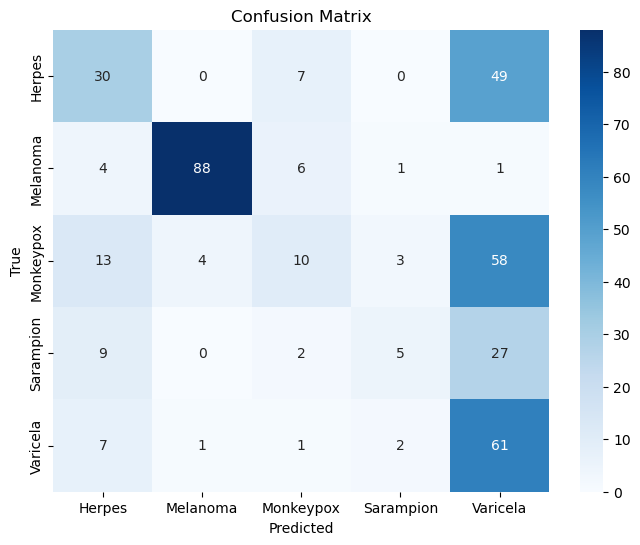

Precision of the MLP :	0.5145624728574038
Recall of the MLP    :	0.4611949729856707
F1 Score of the Model :	0.4260898648954827


In [71]:
# Test code for above function
confusion_matrix_and_metrics(custom_cnn, test_dataloader, device)

In [94]:
# Implementation of Bayesian Optimization to improve Hyper Parameters

# Representation of how our model is changed
def objective(params):
    
    learning_rate = params[0][0]
    batch_size = int(params[0][1])
    dropout = params[0][2]
    kernel = int(params[0][3])
    channels = int(params[0][4])
    
    custom_cnn = CustomCNN(dropout, kernel, channels).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(custom_cnn.parameters(), lr = learning_rate)

    train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
    val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

    custom_cnn.train()
    for epoch in range(20):
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = custom_cnn(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    custom_cnn.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
    
            outputs = custom_cnn(images)
            _, predicted = torch.max(outputs, 1)
    
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    print(-accuracy)
    return -accuracy

In [95]:
# Range of tested values in Bayesian Optimization
domain = [
    {"name": "learning_rate", "type": "continuous", "domain": (1e-5, 1e-2)},
    {"name": "batch_size", "type": "discrete", "domain": [25, 50, 100, 200]},
    {"name": "dropout", "type": "continuous", "domain": (0.1, 0.7)},
    {"name": "kernel", "type": "discrete", "domain": [3, 5, 7]},
    {"name": "channels", "type": "discrete", "domain": [8, 16, 32, 64, 128]}
]

# Run Bayesian Optimization
opt = GPyOpt.methods.BayesianOptimization(f=objective, domain=domain)
opt.run_optimization(max_iter=10)

0.2
0.388
0.316
0.208
0.376
0.416
0.404
0.288
0.604
0.512


In [96]:
# Print Results
best_params = opt.X[np.argmin(opt.Y)]
param_names = ["Learning Rate", "Batch Size", "Dropout", "Kernel Size", "Channels"]

print("Best Hyper Parameters: ")
for param_name, best_param in zip(param_names, best_params):
    if param_name == "Learning Rate" or param_name == "Dropout":
        print(f'{param_name}: {float(best_param)}')
    else:
        print(f'{param_name}: {int(best_param)}')
print(f'Loss: {-np.min(opt.Y)}')

Best Hyper Parameters: 
Learning Rate: 1e-05
Batch Size: 25
Dropout: 0.1
Kernel Size: 3
Channels: 32
Loss: 0.604
